In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [2]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [4]:
DIR_DATA  = '../input/diploma/'

In [5]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [6]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [8]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [9]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [10]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [11]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [12]:
data_d['target'].isna().unique()

array([False,  True])

In [13]:
data_d.loc[data_d['target'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
61,NaN,NaN,Single Family,7353 Boysenberry Ct,2.0,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",Yes,Jacksonville,"[{'rating': ['7/10', '2/10', '4/10'], 'data': ...","1,446 sqft",32244,3,FL,1,NaN,NaN,NaN,NaN
94,Pre-foreclosure / auction,NaN,Townhouse,20663 Fm 2154 Rd,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,College Station,"[{'rating': ['NA', '2/10', 'NA'], 'data': {'Di...","Total interior livable area: 4,179 sqft",77845,4 bd,TX,2.0,NaN,NaN,NaN,NaN
121,/ auction,NaN,Single Family,3719 Suffolk St,2,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",Yes,Durham,"[{'rating': ['2/10', '5/10', '4/10'], 'data': ...","2,327",27707,3,NC,0.0,NaN,NaN,NaN,NaN
169,NaN,NaN,Single Family,8201 Waterford Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",NaN,Tamarac,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...","1,280 sqft",33321,2,FL,1.0,NaN,NaN,NaN,NaN
174,Pre-foreclosure / auction,NaN,Single Family,17508 Puritas Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Cleveland,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...","Total interior livable area: 1,209 sqft",44135,2 bd,OH,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376495,recently sold,NaN,single-family home,7433 Creekland Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Reno,"[{'rating': ['None/10', '5/10', '3/10'], 'data...","1,082 sqft",89506,2 Beds,NV,1,NaN,NaN,NaN,NaN
376528,foreclosure,NaN,apartment,5652 S Justine St,2 Baths,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '1/10', '2/10'], 'data': ...","2,351 sqft",60636,6 Beds,IL,NaN,NaN,NaN,NaN,NaN
376577,Foreclosed,NaN,Single Family,1851 W Landstreet Rd # 3233,NaN,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Orlando,"[{'rating': ['4/10', '2/10', '5/10'], 'data': ...",Total interior livable area: 620 sqft,32809,-- bd,FL,NaN,NaN,NaN,NaN,NaN
376937,NaN,NaN,NaN,8501 NW 53rd Ter,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",NaN,33166,1.74 acres,FL,NaN,NaN,NaN,NaN,NaN


In [14]:
data_d.dropna(axis=0,subset=['target'],inplace=True)

In [15]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

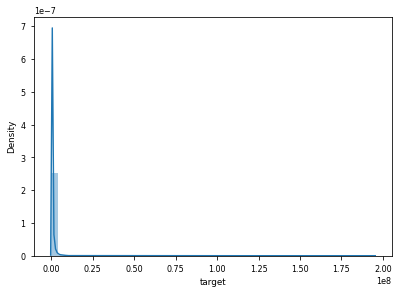

In [16]:
sns.distplot(data_d['target'])

# Удаление выбросов в целевой переменной.

In [17]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [18]:
data_d['target'].mean()

644757.5030263888

In [19]:
data_d.loc[data_d['target']>data_d['target'].mean()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
17,Active,NaN,Townhouse,24 W 126th St,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,NaN,NaN,4975368,2650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377168,for sale,NaN,single-family home,24080 Tuscany Ct,5 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...","5,992 sqft",34134,4 Beds,FL,NaN,NaN,yes,219077435,2495000.0
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0


In [20]:
data_d.loc[data_d['target']>500000]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
12,for sale,NaN,single-family home,16373 NW 16th St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","2,839 sqft",33028,4 Beds,FL,1.0,NaN,yes,A10767242,525000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,674999.0


# Определение максимального и минимального значения для последующей нормализации.

In [262]:
data_d.loc[data_d['target'].min()]

status                                                       for_sale
private pool                                                      NaN
propertyType                                                    other
street                                              12911 E Heroy Ave
baths                                                             3.0
homeFacts                        [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                           0
city                                                           others
schools             {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                           1947.0
zipcode                                                            99
beds                                                                3
state                                                              WA
stories                                                           2.0
mls-id              

In [271]:
data_d['target'].value_counts(normalize=True, sort=True, ascending=False,bins=10)

(-149999.0, 15000000.9]       0.998404
(15000000.9, 30000000.8]      0.001241
(30000000.8, 45000000.7]      0.000223
(45000000.7, 60000000.6]      0.000091
(60000000.6, 75000000.5]      0.000027
(75000000.5, 90000000.4]      0.000008
(105000000.3, 120000000.2]    0.000003
(135000000.1, 150000000.0]    0.000003
(90000000.4, 105000000.3]     0.000000
(120000000.2, 135000000.1]    0.000000
Name: target, dtype: float64

In [272]:
normalization_coef = 150000000 - 310000
normalization_coef

149690000

In [21]:
#data_d = data_d[(data_d['target'] < 550000)]

# Визуализация целевой переменной.

<AxesSubplot:xlabel='target', ylabel='Density'>

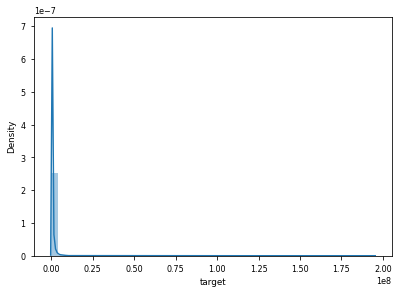

In [22]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f93d454cf90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f93d453eb90>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f93d454ced0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f93d453eb10>}

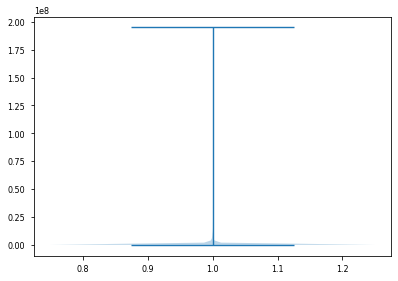

In [23]:
plt.violinplot(data_d['target'])

In [24]:
data_d['target'].isna().unique()

array([False])

In [25]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [26]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [27]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [28]:
#data_d['target'].isna().unique()

# Обработка признака homeFacts.

In [29]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN


In [30]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))
t = data_d['homeFacts']
t_lst = t.tolist()
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']
t1 = pd.DataFrame(t_lst, columns = columns)
data_d = data_d.join(t1)

In [31]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335447 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340150 non-null  object 
 3   street          374702 non-null  object 
 4   baths           269328 non-null  object 
 5   homeFacts       374704 non-null  object 
 6   fireplace       102522 non-null  object 
 7   city            374670 non-null  object 
 8   schools         374704 non-null  object 
 9   sqft            334582 non-null  object 
 10  zipcode         374704 non-null  object 
 11  beds            283748 non-null  object 
 12  state           374704 non-null  object 
 13  stories         224910 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310226 non-null  object 
 17  target    

# Разбор признака школы.

In [32]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))
t = data_d['schools']
t_lst = t.tolist()
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

df_lst = pd.DataFrame(t5_lst,dtype=str)
data_d = data_d.join(df_lst)

In [33]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335447 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340150 non-null  object 
 3   street          374702 non-null  object 
 4   baths           269328 non-null  object 
 5   homeFacts       374704 non-null  object 
 6   fireplace       102522 non-null  object 
 7   city            374670 non-null  object 
 8   schools         374704 non-null  object 
 9   sqft            334582 non-null  object 
 10  zipcode         374704 non-null  object 
 11  beds            283748 non-null  object 
 12  state           374704 non-null  object 
 13  stories         224910 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310226 non-null  object 
 17  target    

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [34]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [35]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [36]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [37]:
data_d.loc[data_d['sqft'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000.0,,,,,,"10,019 sqft",None,"['4/10', '5/10', '5/10']","['5.96mi', '3.25mi', '3.03mi']","['7-8', '9-12', 'PK-6']","['Southwest Middle School', 'Bayside High Scho..."
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",NaN,Memphis,"{'rating': ['4', '2', '2'], 'data': {'Distance...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,68000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid..."
15,New,NaN,2 Story,930 52nd St,NaN,"[1905, 1905, , Steam Heating, , 2,003 Sq. Ft.,...",NaN,Brooklyn,"{'rating': ['8', '8', '3'], 'data': {'Distance...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0,1905,1905,,Steam Heating,,"2,003 Sq. Ft.",None,"['8', '8', '3']","['0.2 mi', '0.2 mi', '1.5 mi']","['K to 5', '6 to 8', '9 to 12']","['PS 160 William T Sampson', 'Junior High Scho..."
26,Active,NaN,NaN,5755 SW 123 Ave,"1,000","[, , , , , —, None]",NaN,Miami,"{'rating': ['9', '10', 'NR', '6', '3'], 'data'...",NaN,33183,Baths,FL,NaN,NaN,NaN,A10787617,799000.0,,,,,,—,None,"['9', '10', 'NR', '6', '3']","['1.0 mi', '13.7 mi', '7.9 mi', '0.9 mi', '1.2...","['Preschool to 5', 'Preschool to 8', 'K to 9',...","['Royal Green Elementary School', 'Air Base El..."
40,Active,NaN,NaN,1104 Rotonda Cir,NaN,"[, , , , , —, None]",NaN,ROTONDA WEST,"{'rating': ['6', '6', '7'], 'data': {'Distance...",NaN,33947,NaN,FL,NaN,NaN,NaN,D6107075,54000.0,,,,,,—,None,"['6', '6', '7']","['3.1 mi', '3.2 mi', '5.6 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Vineland Elementary School', 'L. A. Ainger M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,Active,NaN,NaN,Mantova Ct,NaN,"[, , , , , —, None]",NaN,ORLANDO,"{'rating': ['7', '6', 'NR', 'NR', '7'], 'data'...",NaN,32836,NaN,FL,NaN,NaN,NaN,O5763033,400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377146,for sale,NaN,single-family home,206/208 N Randolph St,NaN,"[1910, , , , , 5488 sqft, None]",NaN,Indianapolis,"{'rating': ['1/10'], 'data': {'Distance': ['0....",NaN,46201,NaN,IN,NaN,NaN,NaN,21686741,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377154,Active,NaN,NaN,2104 Russell Ave,NaN,"[, , , , , 6,970 Sq. Ft., None]",NaN,Charlotte,"{'rating': ['2', '3', '3'], 'data': {'Distance...",NaN,28216,NaN,NC,NaN,NaN,NaN,3571015,99990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377161,Active,NaN,Land,Homestead Dr Lot 1,NaN,"[, , , , , 1, None]",NaN,Columbiana,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",NaN,44408,NaN,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_d[['sqft']] = data_d[['sqft']].fillna(data_d['sqft'].median())

In [39]:
data_d['sqft'].isna().sum()

0

In [40]:
data_d.loc[data_d['sqft'].min()]

status                                                     for sale
private pool                                                    NaN
propertyType                                     single-family home
street                                            12911 E Heroy Ave
baths                                                       3 Baths
homeFacts                      [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                       NaN
city                                                 Spokane Valley
schools           {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                         1947.0
zipcode                                                       99216
beds                                                         3 Beds
state                                                            WA
stories                                                         2.0
mls-id                                          

<AxesSubplot:xlabel='sqft', ylabel='Density'>

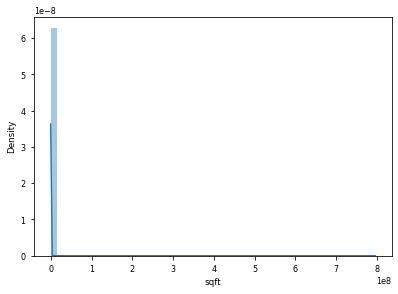

In [41]:
sns.distplot(data_d['sqft'])

In [42]:
data_d.loc[data_d['sqft'].median()]

status                                                     for sale
private pool                                                    NaN
propertyType                                                  condo
street                                     2025 SE Caruthers St #24
baths                                                           NaN
homeFacts                  [1941, 1941, Baseboard, , , , $398/sqft]
fireplace                                                       yes
city                                                       Portland
schools           {'rating': ['9/10', '7/10', '6/10'], 'data': {...
sqft                                                          626.0
zipcode                                                       97214
beds                                                            NaN
state                                                            OR
stories                                                         1.0
mls-id                                          

In [43]:
data_d['sqft_big'] = data_d['sqft'].apply(lambda x: 1 if x > 2300 else 0)

In [44]:
data_d.sqft = data_d.sqft.apply(lambda x: 2301 if x>2300 else x)

# Визуализация признака площадь

<AxesSubplot:xlabel='sqft', ylabel='Density'>

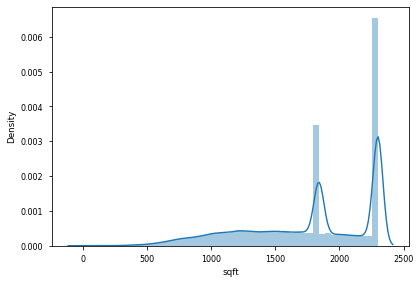

In [45]:
sns.distplot(data_d['sqft'])


Text(0.5, 1.0, 'Зависимость цены от площади')

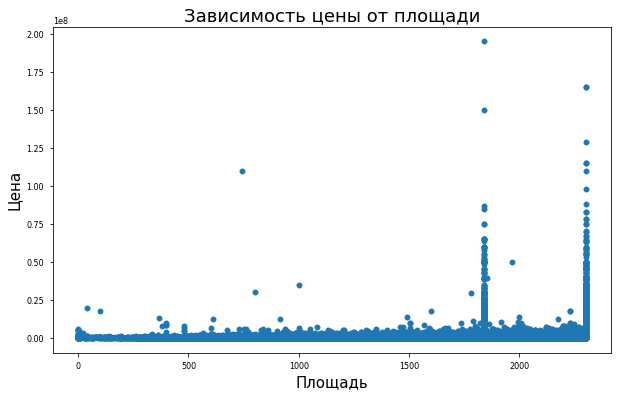

In [46]:
x = data_d['sqft']
y = data_d['target']
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

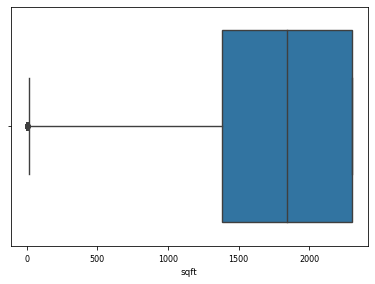

In [47]:
sns.boxplot(data_d['sqft'])

# Спальни - приведение к численному виду.

In [48]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"[1922, , , , , 1079000, None]",NaN,Falconer,"{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'data...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0,1955,,Gas,,"Carport, Attached Garage","7,501 sqft lot",$130,"['6/10', '2/10', '2/10']","['0.2 mi', '0.9 mi', '0.8 mi']","['PK-5', '6-8', '9-12']","['Henderson J Elementary School', 'Jackson Mid...",0


In [49]:
#data_d = data_d.drop(data_d['beds'] == '# Bedrooms 1st Floor')

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [50]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [51]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [52]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1          211598
3 Beds      53077
4 Beds      35225
2 Beds      26196
3 bd        12678
            ...  
23 bd           1
31 Beds         1
27 bd           1
26 bd           1
88 Beds         1
Name: beds, Length: 74, dtype: int64

In [53]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big


Вспомогательная функция для выбора числового значения признака спальни.

In [54]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [55]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [56]:
data_d['beds'].unique()                        


array([ 1,  3,  5,  2,  4,  8,  6, 12,  7,  9, 16, 13, 18, 10, 20, 26, 64,
       22, 11, 24, 14, 28, 32, 15, 36, 19, 25, 17, 27, 47, 23, 44, 31, 34,
       78, 48, 40, 33, 53, 51, 30, 39, 42, 21, 52, 46, 76, 88])

In [57]:
data_d['beds'].isna().sum()

0

In [58]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335447 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340150 non-null  object 
 3   street          374702 non-null  object 
 4   baths           269328 non-null  object 
 5   homeFacts       374704 non-null  object 
 6   fireplace       102522 non-null  object 
 7   city            374670 non-null  object 
 8   schools         374704 non-null  object 
 9   sqft            374704 non-null  float64
 10  zipcode         374704 non-null  object 
 11  beds            374704 non-null  int64  
 12  state           374704 non-null  object 
 13  stories         224910 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310226 non-null  object 
 17  target    

# Визуализация и обработка признака спальни (beds).

In [59]:
data_d['beds_big']= data_d['beds'].apply(lambda x: 1 if x>7 else 0)

In [60]:
data_d.beds = data_d.beds.apply(lambda x: 11 if x>10 else x)

In [61]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335447 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340150 non-null  object 
 3   street          374702 non-null  object 
 4   baths           269328 non-null  object 
 5   homeFacts       374704 non-null  object 
 6   fireplace       102522 non-null  object 
 7   city            374670 non-null  object 
 8   schools         374704 non-null  object 
 9   sqft            374704 non-null  float64
 10  zipcode         374704 non-null  object 
 11  beds            374704 non-null  int64  
 12  state           374704 non-null  object 
 13  stories         224910 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310226 non-null  object 
 17  target    

In [62]:
data_d['beds'].isna().sum()

0

<AxesSubplot:xlabel='beds', ylabel='Density'>

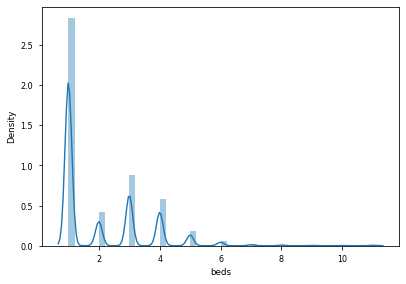

In [63]:
sns.distplot(data_d['beds'])

In [64]:
y = data_d['target']

In [65]:
x = data_d['beds']

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

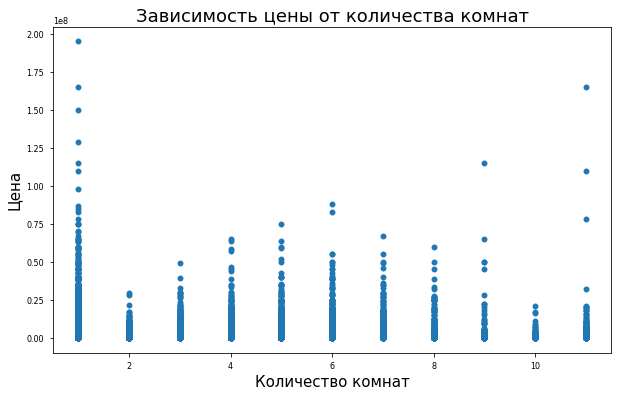

In [66]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


<AxesSubplot:xlabel='beds'>

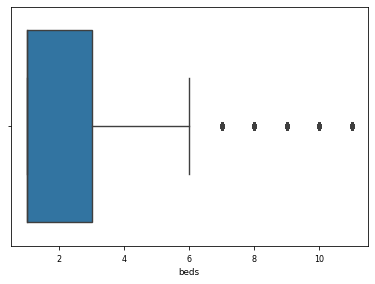

In [67]:
sns.boxplot(data_d['beds'])

# Ванны - приведение к численному виду.

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [68]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [69]:
data_d.baths = data_d.baths.apply(lambda x: round(main_extract_num(str(x)),1))

In [70]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 2.00e+00, 8.00e+00, 1.00e+00, 4.00e+00,
       5.00e+00, 7.00e+00, 2.10e+00, 2.50e+00, 4.50e+00, 6.00e+00,
       5.50e+00, 1.50e+00, 0.00e+00, 9.00e+00, 1.20e+01, 7.50e+02,
       1.00e+01, 1.90e+01, 7.50e+00, 1.80e+01, 1.10e+01, 1.80e+00,
       6.50e+00, 1.60e+01, 1.30e+01, 1.40e+01, 8.50e+00, 1.10e+00,
       1.70e+01, 2.41e+02, 1.05e+01, 2.00e+01, 4.00e+01, 2.80e+00,
       2.40e+01, 2.20e+01, 2.20e+00, 3.10e+00, 3.20e+00, 3.20e+01,
       2.70e+01, 2.60e+01, 9.50e+00, 1.50e+01, 3.50e+01, 3.80e+00,
       2.90e+01, 1.16e+02, 2.10e+01, 5.20e+00, 1.45e+01, 7.60e+01,
       2.30e+01, 4.30e+01, 1.20e+00, 3.40e+01, 5.50e+01, 2.50e+01,
       1.25e+01, 4.40e+01, 5.00e-01, 4.20e+00, 4.80e+00, 8.00e-01,
       4.10e+00, 4.10e+01, 3.60e+01, 3.00e+01, 2.80e+01, 6.40e+01,
       1.15e+01, 3.90e+01, 4.20e+01, 6.00e+01, 6.80e+00, 6.80e+01])

In [71]:
data_d['baths'].isna().sum()

0

In [72]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335447 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    340150 non-null  object 
 3   street          374702 non-null  object 
 4   baths           374704 non-null  float64
 5   homeFacts       374704 non-null  object 
 6   fireplace       102522 non-null  object 
 7   city            374670 non-null  object 
 8   schools         374704 non-null  object 
 9   sqft            374704 non-null  float64
 10  zipcode         374704 non-null  object 
 11  beds            374704 non-null  int64  
 12  state           374704 non-null  object 
 13  stories         224910 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40121 non-null   object 
 16  MlsId           310226 non-null  object 
 17  target    

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

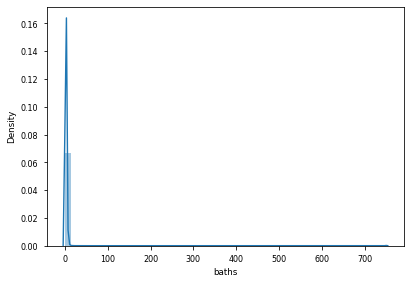

In [73]:
sns.distplot(data_d['baths'])

In [74]:
data_d.loc[data_d['baths']>10]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
459,for sale,NaN,single-family home,943 Konga Dr,12.0,"[2010, 2010, Forced Air, Central, Attached Gar...",yes,Las Vegas,"{'rating': ['7/10', '5/10', 'None/10'], 'data'...",2301.0,89123,9,NV,2.0,NaN,yes,2063700,3500000.0,1895,,,,Detached Garage,"2,952 sqft",None,"['1/10', '1/10', '3/10']","['1.2mi', '8.76mi', '0.19mi']","['9-12', '9-12', 'PK-8']","['Orr Academy High School', 'Hope College Prep...",1,1
1109,Active,NaN,"Attached or 1/2 Duplex, Traditional",3624 Douglas Ave,750.0,"[1993, 1993, , Central A/C (Electric), Central...",1,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",1758.0,75219,1,TX,NaN,NaN,NaN,14240509,499000.0,1963,1964,Forced Air,Central,,,$221/sqft,"['10/10', '7/10', '5/10']","['2.3mi', '2.75mi', '2.32mi']","['K-5', '9-12', '6-8']","['Bayview Elementary School', 'Fort Lauderdale...",0,0
1349,For sale,NaN,Multi Family,1501 1503 1513 S Walnut St # 106,19.0,"[1920, , Gas, Central, 19 spaces, 6 acres lot,...",NaN,Bloomington,"{'rating': ['7/10', '6/10'], 'data': {'Distanc...",2301.0,47401,11,IN,2.0,201931321,NaN,NaN,1500000.0,1952,1982,Baseboard,Central,Attached Garage,0.44 acres,$255/sqft,"['None/10', '9/10', '9/10', '9/10']","['1.6mi', '0.36mi', '0.71mi', '0.69mi']","['PK-2', '3-5', '9-12', '6-8']","['Goldwood Primary Elementary School', 'Kensin...",1,1
1727,For sale,NaN,Single Family,2890 Dudley Ave,12.0,"[1930, , Oil, , Carport, 2,374 sqft, $341]",NaN,Bronx,"{'rating': ['7/10', '3/10'], 'data': {'Distanc...",1726.0,10461,3,NY,NaN,QCZD7N,NaN,NaN,589000.0,2016,,,,,"7,560 sqft",$164/sqft,"['7/10', '7/10', '5/10']","['0.65mi', '5.98mi', '6.91mi']","['PK-6', '9-12', '6-8']","['John S. Wash Elementary School', 'Sanger Hig...",0,0
2022,Active,NaN,NaN,920 I St NW #411,750.0,"[2013, , , , , —, $1097 / Sq. Ft.]",NaN,Washington,"{'rating': ['8', '8', '3', '8'], 'data': {'Dis...",1367.0,20001,1,DC,NaN,NaN,NaN,DCDC449992,1499000.0,2001,None,Forced air,Central,2 spaces,"7,405 sqft",$97,"['4/10', '3/10', '3/10']","['0.1 mi', '1.4 mi', '1.1 mi']","['PK-5', '6-8', '9-12']","['William Paschall Elementary School', 'Kirby ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375634,Active,NaN,"Condo/Townhome, Contemporary/Modern",3225 Turtle Creek Blvd #1646,750.0,"[1998, 1998, , Central A/C (Electric), Central...",NaN,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",832.0,75219,1,TX,NaN,NaN,NaN,14215205,219500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376012,Active,NaN,"Condo/Townhome, Other (See Remarks)",2262 Alterbrook Ln,750.0,"[2019, , , Central A/C (Electric), Central Hea...",NaN,Dallas,"{'rating': ['4', '3', '2', '10'], 'data': {'Di...",2102.0,75219,1,TX,NaN,NaN,NaN,14204976,464900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376147,Active,NaN,"Condo/Townhome, Hi-Rise",3225 Turtle Creek Blvd #528,750.0,"[1998, 1998, , Central A/C (Electric), Central...",NaN,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",837.0,75219,1,TX,22,NaN,NaN,14222399,240000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376772,Active,NaN,"Condo/Townhome, Contemporary/Modern",3811 Throckmorton St,750.0,"[2015, 2015, , Central A/C (Electric), Central...",1,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",2301.0,75219,1,TX,NaN,NaN,NaN,14187254,749999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [75]:
data_d = data_d[data_d['baths']<10]

<AxesSubplot:xlabel='baths', ylabel='Density'>

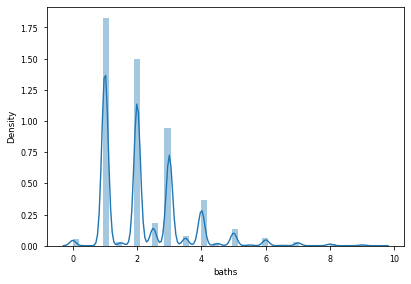

In [76]:
sns.distplot(data_d['baths'])

In [77]:
x = data_d['baths']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от оборудования ванн')

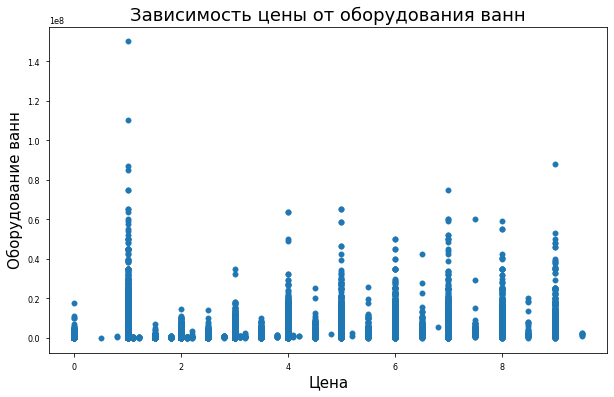

In [78]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [79]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [80]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [81]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [82]:
data_d['fireplace'].isna().sum() 

0

In [83]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373448 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          334265 non-null  object 
 1   private pool    4126 non-null    object 
 2   propertyType    338942 non-null  object 
 3   street          373446 non-null  object 
 4   baths           373448 non-null  float64
 5   homeFacts       373448 non-null  object 
 6   fireplace       373448 non-null  int64  
 7   city            373414 non-null  object 
 8   schools         373448 non-null  object 
 9   sqft            373448 non-null  float64
 10  zipcode         373448 non-null  object 
 11  beds            373448 non-null  int64  
 12  state           373448 non-null  object 
 13  stories         224155 non-null  object 
 14  mls-id          24862 non-null   object 
 15  PrivatePool     39701 non-null   object 
 16  MlsId           309086 non-null  object 
 17  target    

In [84]:
x = data_d['fireplace']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

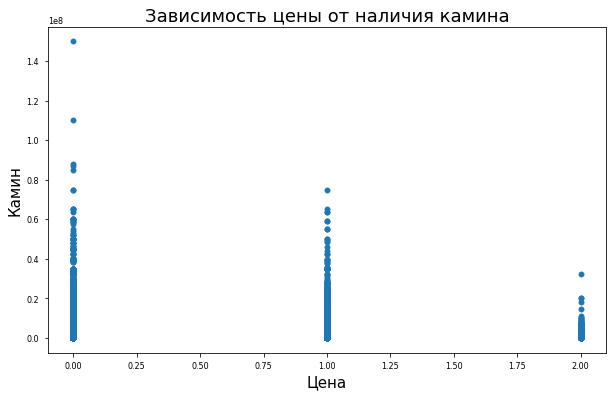

In [85]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [86]:
data_d['private pool'].value_counts()

Yes    4126
Name: private pool, dtype: int64

In [87]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"[1958, 1980, Heat pump, Central, 1 space, 0.45...",1,Tallahassee,"{'rating': ['4/10', '5/10', '7/10'], 'data': {...",2301.0,32308,3,FL,NaN,302221,NaN,NaN,385000.0,2019,,Central,Electric,,—,$258 / Sq. Ft.,"['9', '8', '9']","['5.0 mi', '7.1 mi', '7.7 mi']","['K to 5', '6 to 8', '9 to 12']","['Grassland Elementary School', 'Grassland Mid...",1,0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"[2017, , Forced air, Central, 2 spaces, 3,484 ...",0,Riverside,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0,1913,,Forced Air Heating,Central A/C,"Asphalt Driveway, Off Street",1720,$392,"['7', '4', '3', '6', '4', '6', 'NR', 'NR']","['0.1 mi', '0.8 mi', '0.9 mi', '0.5 mi', '0.4 ...","['PK–8', '6–6', '9–12', 'PK–8', '6–8', '9–12',...","['Truesdell Education Campus School', 'MacFarl...",0,0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"[1976, , Forced air, Central, 2 spaces, -- sqf...",0,Escondido,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,119000.0,,,,,,15960,None,"['2', '1', '3', '3', '2', 'NR', 'NR', 'NR']","['1.2 mi', '2.6 mi', '8.0 mi', '1.9 mi', '8.3 ...","['PK–4', '5–8', 'PK–12', 'PK–4', '6–8', '10–12...","['Laurel Elementary School', 'Lake Marion Cree...",0,0
404,For sale,Yes,Single Family,24448 Epson Ct,3.0,"[1987, , Forced air, Central, 3 spaces, 1.15 a...",0,Murrieta,"{'rating': ['7/10', '6/10', '8/10'], 'data': {...",1832.0,92562,3,CA,1.0,SW19240910,NaN,NaN,899000.0,2006,,Forced Air,Central,,"1,999 sqft",$89/sqft,"['2/10', '2/10', '3/10']","['2.64mi', '0.54mi', '0.57mi']","['9-12', 'PK-5', '6-8']","['Banneker High School', 'Bethune Elementary S...",0,0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"[1964, 1964, Forced air, Central, , 8,624 sqft, ]",1,Jacksonville,"{'rating': ['5/10', '2/10', '4/10'], 'data': {...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,128103.0,1986,,,,,—,None,"['4', '3', '5', '10', '3']","['0.7 mi', '4.1 mi', '0.8 mi', '7.3 mi', '1.8 ...","['K to 5', 'K to 5', '6 to 8', '6 to 12', '9 t...","['Sunrise Elementary School', 'Thacker Avenue ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376627,For sale,Yes,Cooperative,1201 S Riverside Dr Phb # PHB,2.0,"[1963, , Electric, Central, , -- sqft lot, $270]",0,Pompano Beach,"{'rating': ['6/10', '4/10', '3/10'], 'data': {...",2200.0,33062,3,FL,4.0,F10163349,NaN,NaN,595000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"[1979, 1979, Forced air, Central, 2 spaces, 7,...",0,Ontario,"{'rating': ['7/10', '6/10', '5/10'], 'data': {...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376694,For sale,Yes,Condo,5980 Shore Blvd S APT 312,3.0,"[1972, 1981, Forced air, Central, 1 space, -- ...",0,Gulfport,"{'rating': ['2/10', '2/10', '4/10'], 'data': {...",2210.0,33707,2,FL,9.0,U8064383,NaN,NaN,435000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376853,For sale,Yes,Townhouse,3188 NE Oregon St,4.0,"[2019, 2019, Forced air, Central, 2 spaces, --...",1,Portland,"{'rating': ['9/10', '7/10'], 'data': {'Distanc...",2301.0,97232,4,OR,3.0,19591180,NaN,NaN,674900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [88]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.268668
Single Family                                                  0.181869
Single Family Home                                             0.093512
condo                                                          0.076287
lot/land                                                       0.060571
                                                                 ...   
Contemporary, Farmhouse                                        0.000003
Contemporary, Modernist, Ranch, Rustic                         0.000003
1 Story, Contemporary, Traditional, Mediterranean              0.000003
A-Frame, Victorian/Federal                                     0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: propertyType, Length: 1267, dtype: float64

In [89]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [90]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [91]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [92]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [93]:
data_d['propertyType'].value_counts()

other      284791
condo       50792
twnh        18452
mlf         12103
ctmp         4355
sn_dtch      2855
eng            55
loft           45
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [94]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes
data_d['propertyType_cat'] = data_d['propertyType_cat'].astype('category')

In [95]:
data_d['propertyType_cat'].isna().sum() 

0

In [96]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373448 entries, 0 to 377184
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            334265 non-null  object  
 1   private pool      4126 non-null    object  
 2   propertyType      373448 non-null  category
 3   street            373446 non-null  object  
 4   baths             373448 non-null  float64 
 5   homeFacts         373448 non-null  object  
 6   fireplace         373448 non-null  int64   
 7   city              373414 non-null  object  
 8   schools           373448 non-null  object  
 9   sqft              373448 non-null  float64 
 10  zipcode           373448 non-null  object  
 11  beds              373448 non-null  int64   
 12  state             373448 non-null  object  
 13  stories           224155 non-null  object  
 14  mls-id            24862 non-null   object  
 15  PrivatePool       39701 non-null   object  
 16  Ml

In [97]:
x = data_d['propertyType_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от типа собственности')

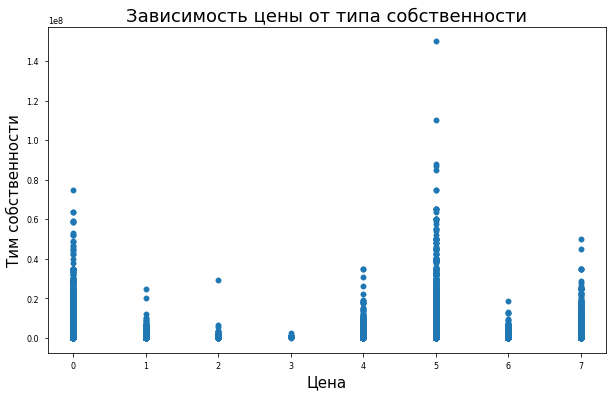

In [98]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [99]:
data_d.city.fillna('others',inplace=True)

In [100]:
data_d['city'].isna().sum()

0

In [101]:
t = data_d['city'].value_counts()

In [102]:
t_df = pd.DataFrame(t)

In [103]:
t_df.loc[t_df['city']==np.NaN]

,city


In [104]:
t_df['city'].isna().sum()

0

In [105]:
dict_t = t_df.to_dict()

In [106]:
dict_city = dict_t.get('city')

In [107]:
data_d['city'].isna().sum()

0

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [108]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [109]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [110]:
data_d.loc[data_d['city']=='others']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28387,1,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5
6,Active,NaN,other,552 Casanova Ct,1.0,"[2006, 2006, Electric, Heat Pump, Central Air,...",0,others,"{'rating': ['3', '3', '1', 'NR'], 'data': {'Di...",1507.0,34759,1,FL,One,NaN,NaN,S5026943,181500.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5
8,Active,NaN,other,11182 Owl Ave,2.0,"[1970, , Forced Air, Central, , 124582, $68]",0,others,"{'rating': ['2', '2', '4', '7', '4', 'NR'], 'd...",2301.0,50401,1,IA,NaN,NaN,NaN,190988,244900.0,1970,,Forced Air,Central,,124582,$68,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter...",1,0,5
13,New construction,NaN,other,1538 Umpqua Dr,2.0,"[2019, 2019, Forced air, , Attached Garage, 7,...",0,others,"{'rating': ['7/10', '7/10', '8/10'], 'data': {...",1820.0,97401,3,OR,1.0,19221142,NaN,NaN,499900.0,2019,2019,Forced air,,Attached Garage,"7,000 sqft lot",$275,"['7/10', '7/10', '8/10']","['1.2 mi', '1.1 mi', '1 mi']","['K-5', '6-8', '9-12']","['Willagillespie Elementary School', 'Monroe M...",0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377134,New construction,NaN,condo,4282 Lahaina Dr,2.0,"[2019, None, Forced air, None, 3 spaces, None,...",0,others,"{'rating': ['9/10', '7/10', '9/10'], 'data': {...",1660.0,92649,1,CA,1,NaN,Yes,OC19273522,815881.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
377140,for sale,NaN,other,6383 Cathedral Dr,1.0,"[, , , , , 3.34 acres, None]",0,others,"{'rating': ['5/10', '5/10', '7/10'], 'data': {...",1840.0,28601,1,NC,NaN,NaN,NaN,3525591,41000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377147,Active,NaN,other,1022 Lyndon Station Dr,1.0,"[2020, , , Central Air, Gas (Hot Air), Multi-Z...",0,others,"{'rating': ['8', '4', '7'], 'data': {'Distance...",2058.0,28134,1,NC,NaN,NaN,NaN,3576461,342969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377161,Active,NaN,other,Homestead Dr Lot 1,1.0,"[, , , , , 1, None]",0,others,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",1840.0,44408,1,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5


In [111]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(sparse=False)

In [112]:
#ohe_ftrs = ohe.fit_transform(data_d['city'].values.reshape(-1,1))

In [113]:
#tmp = pd.DataFrame(ohe_ftrs, columns = ['city=' + str(i) for i in range(ohe_ftrs.shape[1])])
#data_d = pd.concat([data_d, tmp], axis=1)


In [114]:
#data_d['city=97'].isna().sum()

In [115]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes
data_d['city_cat'] = data_d['city_cat'].astype('category')

<AxesSubplot:xlabel='city_cat', ylabel='Density'>

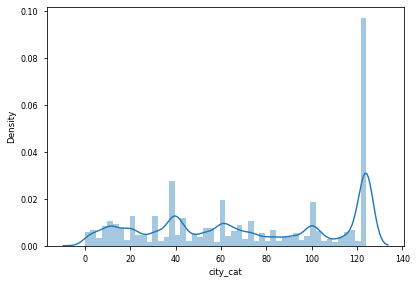

In [116]:
sns.distplot(data_d['city_cat'])

In [117]:
data_d['city_cat'].isna().sum()

0

In [118]:
x = data_d['city_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от города')

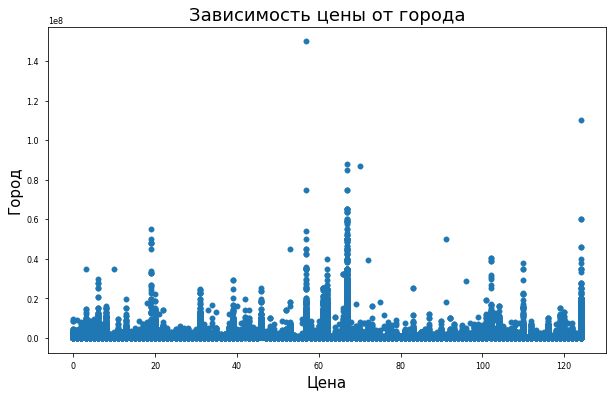

In [119]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Город', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

In [120]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373448 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            334265 non-null  object  
 1   private pool      4126 non-null    object  
 2   propertyType      373448 non-null  category
 3   street            373446 non-null  object  
 4   baths             373448 non-null  float64 
 5   homeFacts         373448 non-null  object  
 6   fireplace         373448 non-null  int64   
 7   city              373448 non-null  category
 8   schools           373448 non-null  object  
 9   sqft              373448 non-null  float64 
 10  zipcode           373448 non-null  object  
 11  beds              373448 non-null  int64   
 12  state             373448 non-null  object  
 13  stories           224155 non-null  object  
 14  mls-id            24862 non-null   object  
 15  PrivatePool       39701 non-null   object  
 16  Ml

# Штат

In [121]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes
data_d['state_cat'] = data_d['state_cat'].astype('category')

In [122]:
data_d['state_cat'].isna().sum()

0

In [123]:
x = data_d['state_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от штата')

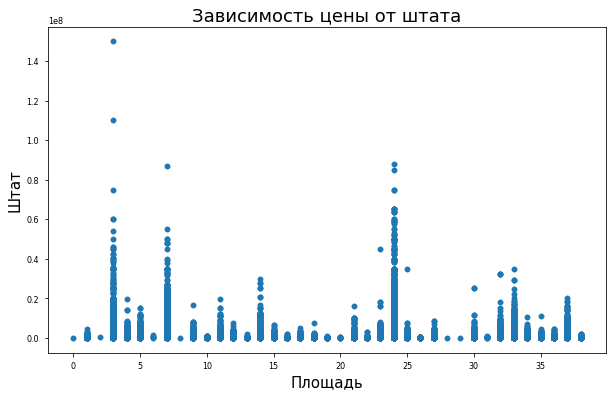

In [124]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [125]:
data_d['street'].nunique()

333727

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [126]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [127]:
data_d['stories'].isna().sum()

0

<AxesSubplot:xlabel='stories', ylabel='Density'>

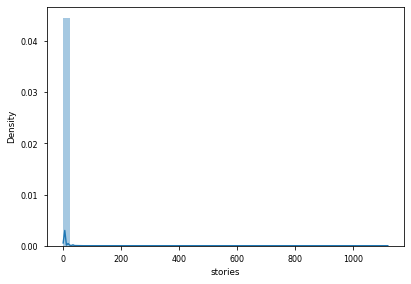

In [128]:
sns.distplot(data_d['stories'])

In [129]:
data_d.loc[data_d['stories']>17]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat
612,for sale,NaN,condo,600 NE 36th St #519,2.0,"[1973, 2005, Forced Air, Central, Attached Gar...",0,Miami,"{'rating': ['2/10', '4/10', '10/10', '2/10', '...",757.0,33137,1,FL,22.0,NaN,NaN,A10584822,245000.0,1964,,,,,—,$406 / Sq. Ft.,"['2', 'NR', '6', 'NR', '4']","['0.3 mi', '0.5 mi', '0.3 mi', '0.5 mi', '2.4 ...","['Preschool to 5', 'Preschool to 8', '6 to 8',...","['Amidon-Bowen Elementary School', 'Waterfront...",0,0,0,61,7
977,for sale,NaN,condo,480 NE 31st St #605,3.0,"[2018, , Forced Air, Central, Attached Garage,...",0,Miami,"{'rating': ['2/10', '4/10', '10/10', '2/10', '...",1322.0,33137,2,FL,54.0,NaN,yes,A10671072,999000.0,1987,,,Central,Attached Garage,0.77 acres,$598/sqft,"['5/10', '8/10', '6/10']","['1.22mi', '0.91mi', '0.28mi']","['9-12', '6-8', 'K-5']","['Forest Hills High School', 'Jhs 190 Russell ...",0,0,0,61,7
988,NaN,NaN,condo,2910 W Barcelona St # 1004,4.0,"[2019, None, Forced air, Central, 2 spaces, No...",0,Tampa,"{'rating': ['9/10', '9/10', '8/10'], 'data': {...",2301.0,33629,1,FL,23.0,NaN,Yes,"1004, Tampa, FL 33629",1583000.0,1960,1992,Forced air,,1 space,"6,969 sqft",,"['3/10', '2/10', '3/10']","['0.6 mi', '0.8 mi', '2.3 mi']","['PK-6', '7-9', '9-12']","['Academy Park School', 'John F. Kennedy Jr Hi...",1,0,0,116,7
1170,for sale,NaN,other,2550 Olinville Ave #2A,1.0,"[1999, , Oil, Central, , 2.24 acres, $263/sqft]",0,Bronx,"{'rating': ['5/10', '7/10', '3/10'], 'data': {...",950.0,10467,2,NY,18.0,NaN,NaN,5104665,250000.0,1983,1983,Other,Central,,9.84 acres lot,$167,"['9/10', '1/10', '7/10']","['1.1 mi', '3 mi', '3.6 mi']","['PK-5', '6-8', '9-12']","['Roberts Elementary School', 'Cullen Middle S...",0,0,5,7,24
1276,for sale,NaN,other,357 E 57th St #9G,1.0,"[1958, , , , , 8,183 sqft, $998/sqft]",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '1...",500.0,10022,1,NY,21.0,NaN,NaN,NaN,499000.0,1990,,,,1 space,,,"['8/10', '7/10', '7/10']","['0.2 mi', '0.4 mi', '1.2 mi']","['K-6', '7-8', '9-12']","['Stanford Elementary School', 'Alamitos Inter...",0,0,5,67,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374845,Active,NaN,ctmp,600 Wall St #3405,1.0,"[2020, , , Heat Pump, High Efficiency, Hot Wat...",0,Seattle,"{'rating': ['2', '6'], 'data': {'Distance': ['...",1135.0,98121,1,WA,40.0,NaN,NaN,1498559,1724950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,104,37
375139,for sale,NaN,condo,45 Park Ave #1503,3.0,"[2008, , , Central, Attached Garage, , $1,594/...",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",1440.0,10016,2,NY,22.0,NaN,NaN,3967902,2295000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,67,24
375325,NaN,NaN,condo,55 SE 6th St APT 3610,2.0,"[2008, 2008, Forced air, Central, 1 space, Non...",0,Miami,"{'rating': ['10/10', '2/10'], 'data': {'Distan...",1200.0,33131,1,FL,43.0,NaN,NaN,A10730974,499000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,61,7
376531,for sale,NaN,condo,75 Wall St #38M,2.0,"[1987, 2008, Forced Air, Central, Attached Gar...",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",1080.0,10005,2,NY,36.0,NaN,NaN,1830955,1750000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,67,24


In [130]:
data_d = data_d[data_d['stories']<17]

In [131]:
x = data_d['stories']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от этажа')

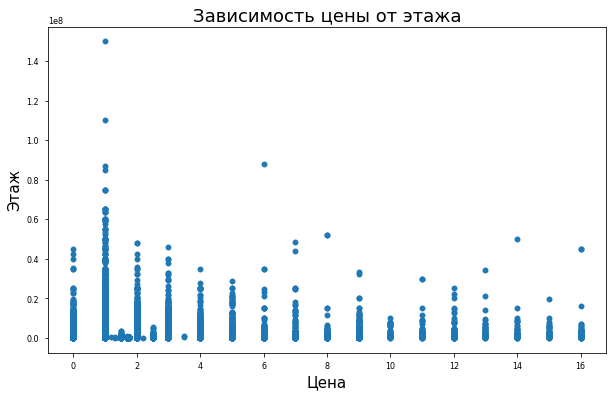

In [132]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [133]:
data_d['status'].value_counts()

for sale                   154625
Active                     104792
For sale                    43137
foreclosure                  5670
New construction             5453
                            ...  
Coming soon: Nov 8.             1
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Coming soon: Dec 23.            1
Name: status, Length: 156, dtype: int64

In [134]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [135]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [136]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [137]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [138]:
data_d['status'].value_counts()

for_sale                 197762
actv                     106137
nan                       39084
frcls                      9293
cnstr                      5453
pnd                        5347
cntrct                     3073
p                          1488
cntgs                       991
 / auction                  799
new                         689
price change                563
auction                     492
for rent                    397
foreclosed                  294
back on market              112
cmg_s                       110
c                            39
pi                           36
listing extended             28
due diligence period         27
c continue show              18
condo for rent                7
apartment for rent            7
closed                        5
ct                            5
accepted offer                4
pf                            4
for sale                      2
accepting backups             2
ps                            2
uc conti

Приведение к численному виду.

In [139]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes
data_d['status_cat'] = data_d['status_cat'].astype('category')

In [140]:
data_d['status_cat'].isna().sum()

0

In [141]:
x = data_d['status_cat']
y = data_d['target']


Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

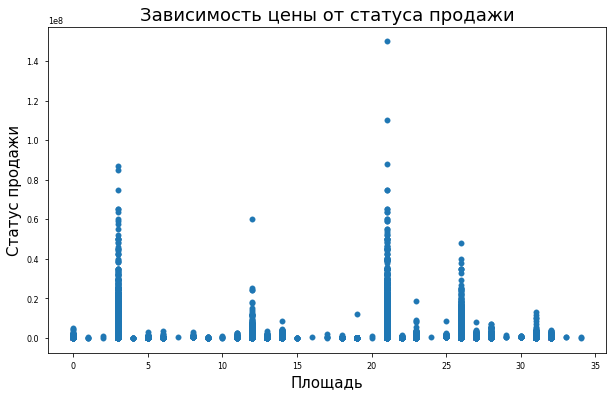

In [142]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [143]:
data_d['zipcode'].value_counts()

32137         2139
33131         1531
34747         1454
78245         1383
34759         1333
              ... 
22308            1
43065            1
27604-6105       1
27603-1994       1
44704            1
Name: zipcode, Length: 4537, dtype: int64

In [144]:
data_d.zipcode = data_d.zipcode.apply(lambda x: (str(x))[0:2])

In [145]:
data_d.loc[data_d['zipcode']=='--']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat
231282,cnstr,NaN,other,0 N Gopher Canyon Rd,1.0,"[, , , , , , ]",0,others,"{'rating': ['7/10', '7/10', '3/10'], 'data': {...",1840.0,--,1,CA,1.0,OC19261036,NaN,NaN,60000000.0,2016,None,Forced air,Central,Attached Garage,None,$552,"['10/10', '2/10']","['20.3 mi', '1.3 mi']","['PK-8', '9-12']","['Air Base Elementary School', 'Booker T. Wash...",0,0,5,124,3,12
235207,nan,NaN,twnh,1744 N Dixie Hwy # 1744,3.0,"[2010, None, Forced air, Central, No Data, No ...",0,Fort Lauderdale,"{'rating': ['3/10', '5/10', '7/10'], 'data': {...",2043.0,--,1,FL,1.0,NaN,NaN,"1744, Fort Lauderdale, FL",425000.0,2000,,Forced air,Central,3 spaces,"8,572 sqft lot",$80,"['7/10', '4/10', '6/10']","['1.4 mi', '1.9 mi', '3.5 mi']","['PK-5', '7-8', '9-12']","['Blackburn Elementary School', 'Pioneer Ridge...",0,0,7,31,7,26


In [146]:
data_d['zipcode'].value_counts()

33    70863
77    32444
32    27974
78    24752
37    15353
      ...  
0         3
--        2
35        1
58        1
00        1
Name: zipcode, Length: 78, dtype: int64

In [147]:
data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)
data_d = data_d.drop(data_d[data_d['zipcode']=='0'].index)
#data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)

In [148]:
data_d.zipcode = data_d.zipcode.apply(lambda x: int(x))

In [149]:
data_d['zipcode'].value_counts()

33    70863
77    32444
32    27974
78    24752
37    15353
      ...  
59        8
42        7
35        1
58        1
0         1
Name: zipcode, Length: 76, dtype: int64

In [150]:
data_d['zipcode'].isna().sum()

0

In [151]:
data_d['zipcode'] = data_d['zipcode'].astype('category')

In [152]:
x = data_d['zipcode']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от индекса')

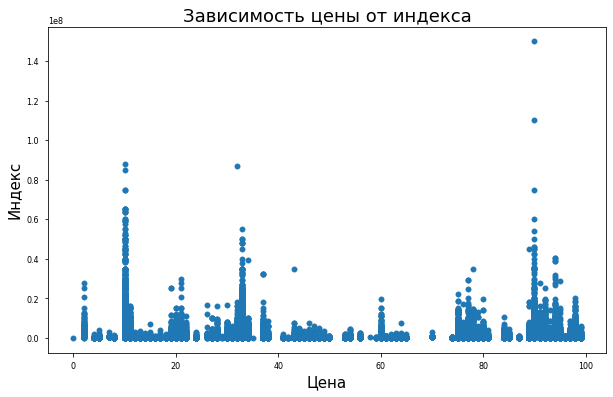

In [153]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Индекс', fontsize = 15)
plt.title('Зависимость цены от индекса', fontsize = 18)

# Обработка признака homeFacts.

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [154]:
#def facts_extraction(slovar):
#    if slovar.find('atAGlanceFacts')>-1:
#        slovar1 = eval(slovar)
#       # print(type(slovar1))
#        #print(slovar1)
#        slovar2=slovar1.get('atAGlanceFacts')
#       # print(type(slovar2))
#       # print(slovar2)
#        
#        lst = ['']
#        for i in slovar2:
#            
#            lst.append(i.get('factValue'))
#        lst_res=lst[1:]
#        return lst_res
#            
#    else: return np.NaN

In [155]:
#data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [156]:
#t = data_d['homeFacts']
#t

In [157]:
#t_lst = t.tolist()

In [158]:
#columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']

In [159]:
#t1 = pd.DataFrame(t_lst, columns = columns)

In [160]:
#data_d = data_d.join(t1)

In [161]:
#data_d.head(3)

In [162]:
#data_d['price_sqft'].unique()

# Обработка признака школы

In [163]:
#data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))

In [164]:
#t = data_d['schools']
#t

In [165]:
#t_lst = t.tolist()

In [166]:
#t5_lst = []
#for i in t_lst:
#    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
#    t5_lst.append(i1)

In [167]:
#df_lst = pd.DataFrame(t5_lst,dtype=str)

In [168]:
#df_lst.head(10)

In [169]:
#data_d = data_d.join(df_lst)

# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [170]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [171]:
data_d['typeRating'].value_counts()

<class 'str'>      369823
<class 'float'>      2447
Name: typeRating, dtype: int64

In [172]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [173]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,2895000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"['8/10', '4/10', '8/10']","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,2395000.0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"['9/10', '9/10', '10/10', '9/10']","['1.05mi', '0.1mi', '1.05mi', '0.81mi']","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>


In [174]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [175]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [176]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [177]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372270 entries, 0 to 377184
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            372270 non-null  category
 1   private pool      4113 non-null    object  
 2   propertyType      372270 non-null  category
 3   street            372268 non-null  object  
 4   baths             372270 non-null  float64 
 5   homeFacts         372270 non-null  object  
 6   fireplace         372270 non-null  int64   
 7   city              372270 non-null  category
 8   schools           372270 non-null  object  
 9   sqft              372270 non-null  float64 
 10  zipcode           372270 non-null  category
 11  beds              372270 non-null  int64   
 12  state             372270 non-null  category
 13  stories           372270 non-null  float64 
 14  mls-id            24842 non-null   object  
 15  PrivatePool       39251 non-null   object  
 16  Ml

# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [178]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [179]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [180]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,2895000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67


# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [181]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [182]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [183]:
data_d['type_Dist'].value_counts()

<class 'str'>    372270
Name: type_Dist, dtype: int64

In [184]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [185]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [186]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65mi, 1.32mi, 1.01mi]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67,<class 'list'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,2895000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","[1.19mi, 2.06mi, 2.63mi]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67,<class 'list'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,2395000.0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9, 9, 10, 9]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>,10,9.25,<class 'list'>


In [187]:
data_d['typeRating'].value_counts()

<class 'str'>      369823
<class 'float'>      2447
Name: typeRating, dtype: int64

In [188]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [189]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [190]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,124,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,124,37,21,<class 'str'>,4,2.67,<class 'list'>
2,for_sale,NaN,other,2005 Westridge Rd,2.0,"[1961, 1967, Forced Air, Central, Attached Gar...",1,Los Angeles,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",2301.0,90,3,CA,1.0,NaN,yes,FR19221027,2895000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8, 4, 8]","[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scien...",1,0,5,57,3,21,<class 'str'>,8,6.67,<class 'list'>
3,for_sale,NaN,other,4311 Livingston Ave,8.0,"[2006, 2006, Forced Air, Central, Detached Gar...",1,Dallas,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",2301.0,75,5,TX,3.0,NaN,NaN,14191809,2395000.0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9, 9, 10, 9]","[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield E...",1,0,5,20,33,21,<class 'str'>,10,9.25,<class 'list'>


# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [191]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

# Выделение нового признака - цена за квадратный метр.

In [192]:
data_d['price_sqft'].isna().sum()

58878

In [193]:
def price_clean(price):
    
    if price == None: return np.NaN
    
    elif type(price) == float: return price

    elif price.find('$')>-1: return price_clean(price[1:])
   
    elif price.find('/')>-1: return price_clean(price[0:price.find('/')])
    
    elif price.isnumeric(): return float(price)
    
    else: return np.NaN

In [194]:
data_d.price_sqft = data_d.price_sqft.apply(lambda x: price_clean(x))

In [195]:
data_d['price_sqft'].isna().sum()

121948

# Для модели, построенной для цены за квадратный метр, заполнение убрать.

In [196]:
data_d[['price_sqft']] = data_d[['price_sqft']].fillna(data_d['price_sqft'].median())

In [197]:
data_d['price_sqft'].isna().sum()

0

# Выбор предварительного датафрейма для модели

In [198]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372270 entries, 0 to 377184
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            372270 non-null  category
 1   private pool      4113 non-null    object  
 2   propertyType      372270 non-null  category
 3   street            372268 non-null  object  
 4   baths             372270 non-null  float64 
 5   homeFacts         372270 non-null  object  
 6   fireplace         372270 non-null  int64   
 7   city              372270 non-null  category
 8   schools           372270 non-null  object  
 9   sqft              372270 non-null  float64 
 10  zipcode           372270 non-null  category
 11  beds              372270 non-null  int64   
 12  state             372270 non-null  category
 13  stories           372270 non-null  float64 
 14  mls-id            24842 non-null   object  
 15  PrivatePool       39251 non-null   object  
 16  Ml

In [199]:
columns = data_d.columns

In [200]:
columns = columns.tolist()

In [201]:
columns

['status',
 'private pool',
 'propertyType',
 'street',
 'baths',
 'homeFacts',
 'fireplace',
 'city',
 'schools',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'stories',
 'mls-id',
 'PrivatePool',
 'MlsId',
 'target',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft',
 'rating',
 'Distance',
 'Grades',
 'name',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'typeRating',
 'max_rating',
 'mean_rating',
 'type_Dist',
 'min_distance',
 'mean_distance']

In [202]:
lst_remove = ['status','mls-id','private pool',
 'PrivatePool','Year built','state',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'MlsId','propertyType','street','homeFacts','city','schools','rating',
 'Distance',
 'Grades',
 'name','typeRating',
 'type_Dist']

In [203]:
columns = columns
lst_remove = lst_remove
for i in lst_remove:
    columns.remove(i)

In [204]:
data_d_preliminary = data_d[columns]

In [205]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372270 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   baths             372270 non-null  float64 
 1   fireplace         372270 non-null  int64   
 2   sqft              372270 non-null  float64 
 3   zipcode           372270 non-null  category
 4   beds              372270 non-null  int64   
 5   stories           372270 non-null  float64 
 6   target            372270 non-null  float64 
 7   price_sqft        372270 non-null  float64 
 8   sqft_big          372270 non-null  int64   
 9   beds_big          372270 non-null  int64   
 10  propertyType_cat  372270 non-null  category
 11  city_cat          372270 non-null  category
 12  state_cat         372270 non-null  category
 13  status_cat        372270 non-null  category
 14  max_rating        372270 non-null  int64   
 15  mean_rating       372270 non-null  float64 
 16  mi

In [206]:
data_d_model_big = data_d_preliminary.loc[data_d_preliminary['target']>=500000]
data_d_model_normal = data_d_preliminary.loc[data_d_preliminary['target']<500000]

In [207]:
data_d_model_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 2 to 377182
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   baths             108806 non-null  float64 
 1   fireplace         108806 non-null  int64   
 2   sqft              108806 non-null  float64 
 3   zipcode           108806 non-null  category
 4   beds              108806 non-null  int64   
 5   stories           108806 non-null  float64 
 6   target            108806 non-null  float64 
 7   price_sqft        108806 non-null  float64 
 8   sqft_big          108806 non-null  int64   
 9   beds_big          108806 non-null  int64   
 10  propertyType_cat  108806 non-null  category
 11  city_cat          108806 non-null  category
 12  state_cat         108806 non-null  category
 13  status_cat        108806 non-null  category
 14  max_rating        108806 non-null  int64   
 15  mean_rating       108806 non-null  float64 
 16  mi

In [208]:
data_d_model_normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263464 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   baths             263464 non-null  float64 
 1   fireplace         263464 non-null  int64   
 2   sqft              263464 non-null  float64 
 3   zipcode           263464 non-null  category
 4   beds              263464 non-null  int64   
 5   stories           263464 non-null  float64 
 6   target            263464 non-null  float64 
 7   price_sqft        263464 non-null  float64 
 8   sqft_big          263464 non-null  int64   
 9   beds_big          263464 non-null  int64   
 10  propertyType_cat  263464 non-null  category
 11  city_cat          263464 non-null  category
 12  state_cat         263464 non-null  category
 13  status_cat        263464 non-null  category
 14  max_rating        263464 non-null  int64   
 15  mean_rating       263464 non-null  float64 
 16  mi

# Визуализация

(13.5, -0.5)

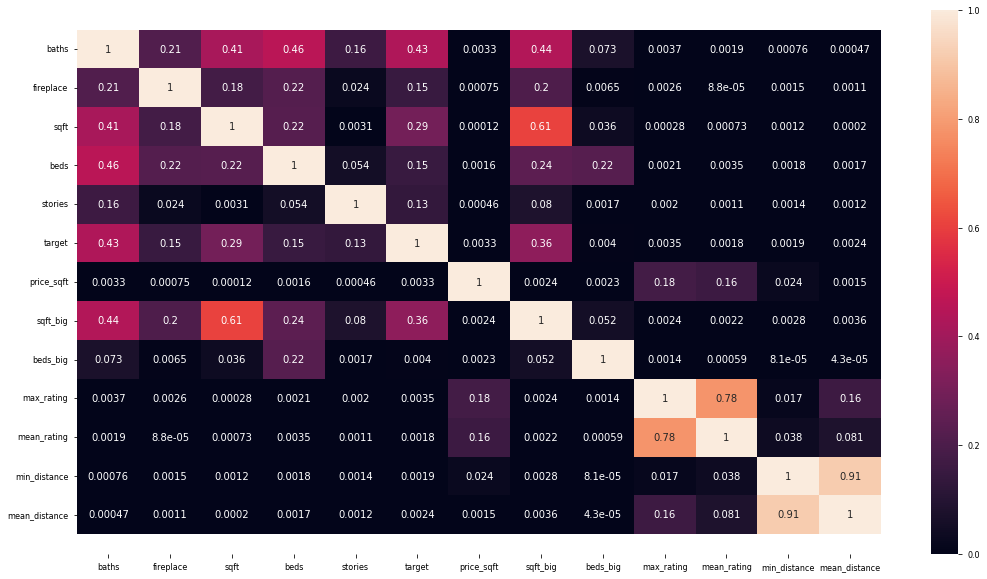

In [209]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_model_normal.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

(13.5, -0.5)

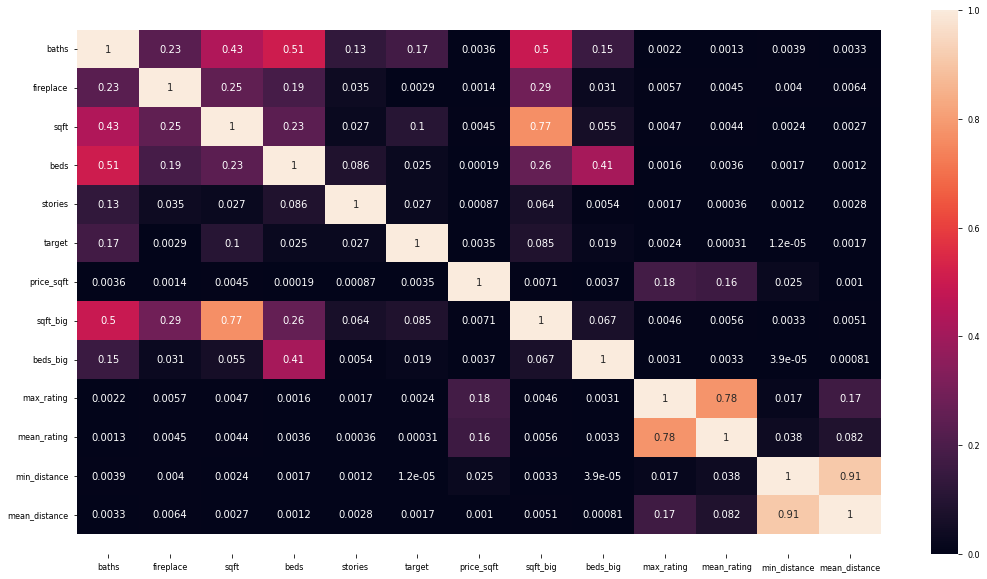

In [210]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_model_big.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [211]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [212]:
#data_d_preliminary.isna().sum()

In [213]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [214]:
#data_d_preliminary = data_d_preliminary.dropna()

In [215]:
#data_d_preliminary.isnull().sum()

# Нормализация

In [216]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [217]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [218]:
# data_d_preliminaty_n

In [219]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Подготовка данных для модели.

In [220]:
columns = data_d_preliminary.columns
columns = columns.tolist()
columns.remove('target')

In [221]:
columns

['baths',
 'fireplace',
 'sqft',
 'zipcode',
 'beds',
 'stories',
 'price_sqft',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'max_rating',
 'mean_rating',
 'min_distance',
 'mean_distance']

In [222]:
X=data_d_preliminary[columns]

In [223]:
y=data_d_preliminary[['target']]

In [224]:
X_big=data_d_model_big[columns]

In [225]:
X_normal=data_d_model_normal[columns]

In [226]:
y_big = data_d_model_big[['target']]

In [227]:
y_normal = data_d_model_normal[['target']]

In [228]:
y.isna().sum()

target    0
dtype: int64

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

In [235]:
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_big, y_big, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

In [236]:
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

In [231]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [232]:
def grafik(y_test,y_pred):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, linewidth=1, label="original")
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
    plt.title("y-test and y-predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

# Линейная регрессия

In [244]:
linearregression = LinearRegression()
linearregression = linearregression.fit(X_train_normal, y_train_normal)
linearregression = linearregression.fit(X_train_big, y_train_big)

y_pred = linearregression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))


MAE: 904147.2787670492
RMSE: 1525956.390455234
R2: -0.1


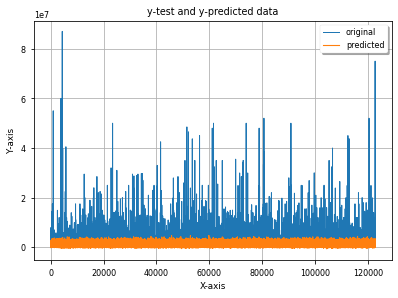

In [245]:
grafik(y_test,y_pred)

In [273]:
linearregression = LinearRegression()
linearregression=linearregression.fit(X_train_big, y_train_big)
linearregression.fit(X_train_normal, y_train_normal)

y_pred = linearregression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))


MAE: 410140.96927044383
RMSE: 1473191.126482044
R2: -0.03


In [280]:
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


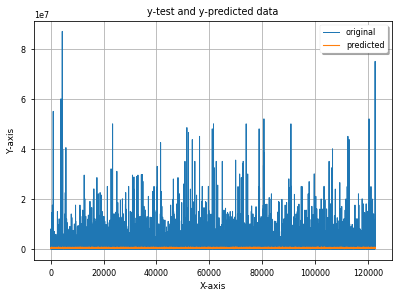

In [281]:
grafik(y_test,y_pred)

# Случайный лес

In [248]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)


model.fit(X_train_normal, y_train_normal) # обучение
model.fit(X_train_big, y_train_big)
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 


R-squared: 0.23232229225020207


In [249]:
y_pred = model.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 686254.3094144985
RMSE: 1278362.8899056024
R2: 0.23


In [279]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


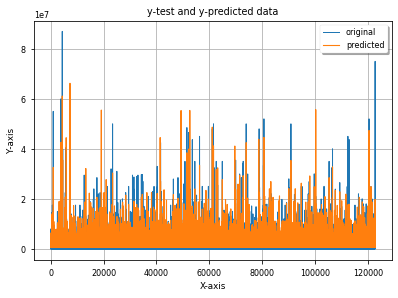

In [250]:
grafik(y_test,y_pred)

# Регрессия с дополнительными деревьями

In [251]:
model = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)



model.fit(X_train_big, y_train_big)
model.fit(X_train_normal, y_train_normal)
predict_extra_tree = model.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
#print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[275633 341435 140193 ...  18122 238666  45844]


In [252]:
y_pred = model.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 347150.2345683069
RMSE: 1468909.4155117548
R2: -0.02


In [282]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


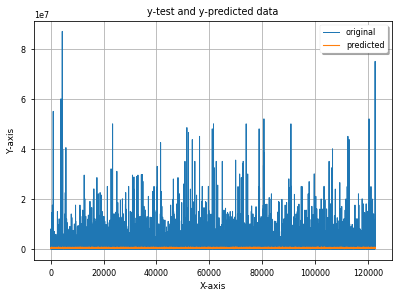

In [283]:
grafik(y_test,y_pred)

# Катбуст

In [254]:
cat_features = ['zipcode','propertyType_cat','state_cat','city_cat','status_cat','sqft_big','beds_big']

In [255]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train_big, y_train_big,
         cat_features = cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )
catboost.fit(X_train_normal, y_train_normal,
         cat_features = cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2269623.3427708	test: 1460014.9061419	best: 1460014.9061419 (0)	total: 261ms	remaining: 4m 21s
100:	learn: 1455784.6179300	test: 1215238.5818546	best: 1215238.5818546 (100)	total: 18.5s	remaining: 2m 44s
200:	learn: 1208486.3014512	test: 1195792.2159561	best: 1193544.1623115 (194)	total: 36.4s	remaining: 2m 24s
300:	learn: 1054412.1293610	test: 1187418.6028756	best: 1184028.2972216 (285)	total: 55.1s	remaining: 2m 7s
400:	learn: 934664.0467509	test: 1183305.9856745	best: 1183276.2134684 (399)	total: 1m 14s	remaining: 1m 50s
500:	learn: 848831.1738407	test: 1184503.3526797	best: 1182252.5362491 (453)	total: 1m 32s	remaining: 1m 32s
600:	learn: 775949.7207931	test: 1184395.9095908	best: 1182252.5362491 (453)	total: 1m 51s	remaining: 1m 13s
700:	learn: 711024.9015689	test: 1186147.4629702	best: 1182252.5362491 (453)	total: 2m 9s	remaining: 55.3s
800:	learn: 661844.8571041	test: 1187316.3470357	best: 1182252.5362491 (453)	total: 2m 28s	remaining: 37s
900:	learn: 616793.7943060	te

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 106615.5657803	test: 1487221.1073554	best: 1487221.1073554 (0)	total: 350ms	remaining: 5m 49s
100:	learn: 74004.8174295	test: 1461427.9605565	best: 1461257.0465678 (84)	total: 32.7s	remaining: 4m 51s
200:	learn: 69300.5195413	test: 1461388.3690341	best: 1461141.0746192 (166)	total: 1m 6s	remaining: 4m 22s
300:	learn: 65777.7622589	test: 1461598.0980090	best: 1461141.0746192 (166)	total: 1m 40s	remaining: 3m 52s
400:	learn: 62547.3739024	test: 1461639.2366540	best: 1461141.0746192 (166)	total: 2m 15s	remaining: 3m 22s
500:	learn: 59415.2862560	test: 1461746.6690904	best: 1461141.0746192 (166)	total: 2m 50s	remaining: 2m 49s
600:	learn: 56942.0385640	test: 1461743.6289828	best: 1461141.0746192 (166)	total: 3m 25s	remaining: 2m 16s
700:	learn: 54713.5604488	test: 1461586.0805471	best: 1461141.0746192 (166)	total: 3m 59s	remaining: 1m 42s
800:	learn: 52663.6135112	test: 1461525.7860707	best: 1461141.0746192 (166)	total: 4m 35s	remaining: 1m 8s
900:	learn: 50846.9114402	test: 1461

In [256]:
y_pred = catboost.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 366246.00467095524
RMSE: 1461141.07423511
R2: -0.01


In [284]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


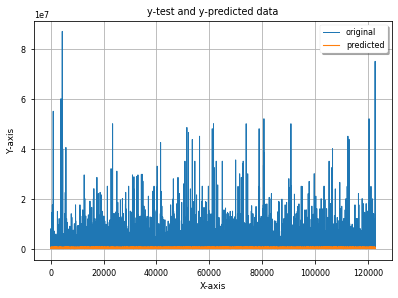

In [257]:
grafik(y_test,y_pred)

Ридж

In [286]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

In [287]:
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(X_train_normal, y_train_normal)
ridge_regression.fit(X_train_big, y_train_big)
print(ridge_regression.predict(X_test))
print(ridge_regression.score(X_test, y_test))

[[ 352901.83322425]
 [1451440.38611795]
 [2279701.29669355]
 ...
 [1369444.69301519]
 [1544504.48601662]
 [1219709.88001775]]
-0.10123922225292215


In [288]:
y_pred = ridge_regression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 904147.2768995295
RMSE: 1525956.2942212208
R2: -0.1


In [289]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


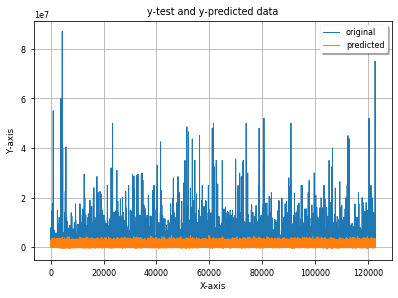

In [290]:
grafik(y_test,y_pred)

Лассо

In [292]:
from sklearn.linear_model import Lasso

In [293]:
lasso_regression = Lasso(alpha=0.1)
lasso_regression.fit(X_train_normal, y_train_normal)
lasso_regression.fit(X_train_big, y_train_big)
print(lasso_regression.predict(X_test))
print(lasso_regression.score(X_test, y_test))

[ 352901.36949392 1451441.05625598 2279700.72775354 ... 1369444.816738
 1544503.82447236 1219709.82306733]
-0.10123931758808635


In [294]:
y_pred = lasso_regression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 904147.2825841648
RMSE: 1525956.3602728506
R2: -0.1


In [295]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


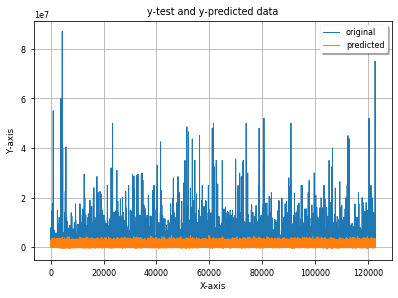

In [296]:
grafik(y_test,y_pred)

Градиентный бустинг

In [297]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train_normal, y_train_normal)
gradient_boosting.fit(X_train_big, y_train_big)

GradientBoostingRegressor()

In [298]:
y_pred = gradient_boosting.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 678675.5823611644
RMSE: 1272373.8083332463
R2: 0.23


In [299]:
RMSE = metrics.mean_squared_error(y_test, y_pred) ** 0.5
RMSE_normalized = round(RMSE/normalization_coef,2)
print('Normalized RMSE:', RMSE_normalized)

Normalized RMSE: 0.01


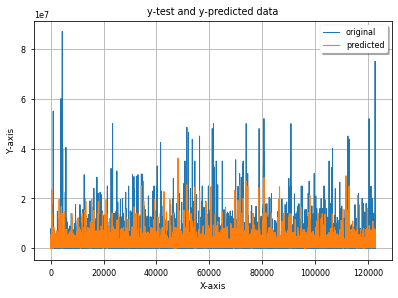

In [300]:
grafik(y_test,y_pred)

# Анализ feature importance

Feature: 0, Score: 323841.93244
Feature: 1, Score: 9811.99049
Feature: 2, Score: 159.11934
Feature: 3, Score: -3147.36112
Feature: 4, Score: -60303.87304
Feature: 5, Score: 7523.68984
Feature: 6, Score: -33.27518
Feature: 7, Score: 187492.52924
Feature: 8, Score: 309029.00780
Feature: 9, Score: -51945.69451
Feature: 10, Score: -675.71979
Feature: 11, Score: -4119.35409
Feature: 12, Score: -13259.65986
Feature: 13, Score: 1004.19084
Feature: 14, Score: 606.27553
Feature: 15, Score: -498.72330
Feature: 16, Score: 221.47274


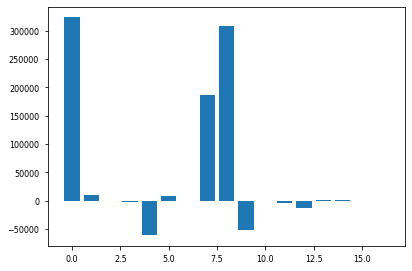

In [301]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

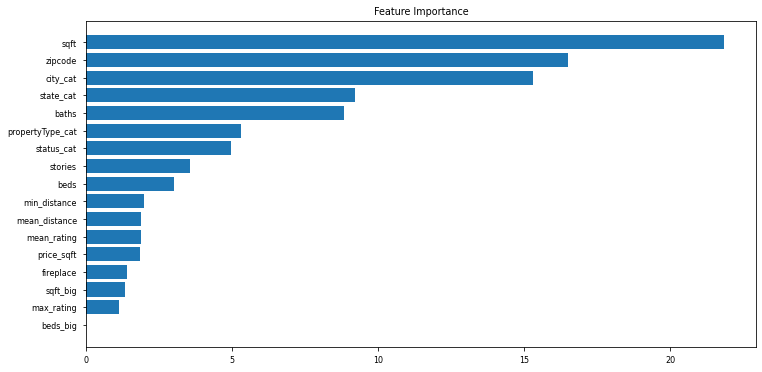

In [302]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')